# Hospital Admission Volume Forecasting

## Project overview
The aim of this project is to forecast **monthly hospital emergency admissions in England** using
publicly available NHS England data.

Accurate forecasts of hospital admissions are important for:
- staffing and rota planning
- bed capacity management
- anticipating winter pressure on the NHS

In this notebook, I:
1. Load and clean NHS admission data from an Excel (XLS) file
2. Explore trends and seasonality
3. Build simple baseline forecasts
4. Compare a statistical time series model (SARIMA) with a machine learning approach
5. Produce a short-term forecast of future admissions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm

## Data source

The dataset is sourced from NHS England and provided as an Excel (XLS) time-series file.
The data contains monthly emergency admissions for multiple regions; this analysis focuses
on **England-level totals**.

In [2]:
# XLS file is in the same folder as this notebook
df_raw = pd.read_excel("nhs_ae_time_series.xls", skiprows=13)

df_raw.head()

,Unnamed: 0,Period,Type 1 Departments - Major A&E,Type 2 Departments - Single Specialty,Type 3 Departments - Other A&E/Minor Injury Unit,Total Attendances,Emergency Admissions via Type 1 A&E,Emergency Admissions via Type 2 A&E,Emergency Admissions via Type 3 and 4 A&E,Total Emergency Admissions via A&E,Other Emergency Admissions (i.e not via A&E),Total Emergency Admissions,Number of patients spending >4 hours from decision to admit to admission,Number of patients spending >12 hours from decision to admit to admission,Unnamed: 14,Operational standard (Performance),Unnamed: 16,0.95
0,NaN,2010-08-01,1.138652e+06,54371.000000,559358.000000,1.752381e+06,287438.000000,5367.000000,8081.000000,300886.000000,124816.000000,425702.000000,3697.000000,1.0,NaN,0.95,NaN,NaN
1,NaN,2010-09-01,1.150728e+06,55181.000000,550359.000000,1.756268e+06,293991.000000,5543.000000,3673.000000,303207.000000,121693.000000,424900.000000,5907.000000,0.0,NaN,0.95,NaN,NaN
2,NaN,2010-10-01,1.163143e+06,54961.000000,583244.000000,1.801348e+06,303452.000000,5485.000000,2560.000000,311497.000000,124718.000000,436215.000000,6932.000000,0.0,NaN,0.95,NaN,NaN
3,NaN,2010-11-01,1.111295e+06,53727.428571,486005.428571,1.651027e+06,297832.000000,5731.142857,3279.000000,306842.142857,122256.857143,429099.000000,7179.000000,2.0,NaN,0.95,NaN,NaN
4,NaN,2010-12-01,1.159204e+06,45536.428571,533000.857143,1.737741e+06,318602.428571,6277.000000,3198.428571,328077.857143,124650.857143,452728.714286,13818.142857,15.0,NaN,0.95,NaN,NaN


Before cleaning the data, I inspect the column names to understand the structure of the NHS dataset
and identify the fields required for the analysis.

In [3]:
df_raw.columns

Index([                                                               'Unnamed: 0',
                                                                          'Period',
                                                  'Type 1 Departments - Major A&E',
                                           'Type 2 Departments - Single Specialty',
                                'Type 3 Departments - Other A&E/Minor Injury Unit',
                                                               'Total Attendances',
                                             'Emergency Admissions via Type 1 A&E',
                                             'Emergency Admissions via Type 2 A&E',
                                       'Emergency Admissions via Type 3 and 4 A&E',
                                              'Total Emergency Admissions via A&E',
                                    'Other Emergency Admissions (i.e not via A&E)',
                                                      'Total Emergency Admis

## Cleaning the dataset

The file includes "junk" columns like `Unnamed:*` and a column whose name is literally `0.95`.
These come from Excel formatting and are not part of the time series.

I keep only:
- `Period` (date)
- `Total Emergency Admissions` (target)


In [4]:
# Drop formatting columns
drop_cols = [c for c in df_raw.columns if str(c).startswith("Unnamed")]
if 0.95 in df_raw.columns:
    drop_cols.append(0.95)

df_clean = df_raw.drop(columns=drop_cols, errors="ignore").copy()

# Keep only needed columns
df_clean = df_clean[["Period", "Total Emergency Admissions"]].copy()

# Parse types
df_clean["Period"] = pd.to_datetime(df_clean["Period"], errors="coerce")
df_clean["Total Emergency Admissions"] = pd.to_numeric(df_clean["Total Emergency Admissions"], errors="coerce")

df_clean = df_clean.dropna().sort_values("Period")
df_clean.head(), df_clean.shape

(      Period  Total Emergency Admissions
 0 2010-08-01               425702.000000
 1 2010-09-01               424900.000000
 2 2010-10-01               436215.000000
 3 2010-11-01               429099.000000
 4 2010-12-01               452728.714286,
 (184, 2))

## Build a monthly time series

I set `Period` as the index and enforce a monthly frequency (`MS` = month start).
This ensures the series is regular and safe for forecasting models.

In [5]:
df_ts = df_clean.rename(columns={"Period": "date", "Total Emergency Admissions": "admissions"})
df_ts = df_ts.set_index("date").sort_index()

# Enforce monthly frequency (month start)
df_ts = df_ts.asfreq("MS")

# Fill missing months if any
df_ts["admissions"] = df_ts["admissions"].interpolate().ffill().bfill()

df_ts.head(12)

,admissions
date,
2010-08-01,425702.000000
2010-09-01,424900.000000
2010-10-01,436215.000000
2010-11-01,429099.000000
2010-12-01,452728.714286
2011-01-01,442003.714286
2011-02-01,401206.428571
2011-03-01,446845.571429
2011-04-01,419243.285714


## Exploratory Data Analysis (EDA)

I visualise:
- the overall trend in admissions
- the distribution of monthly admissions
- the month-of-year pattern (seasonality)


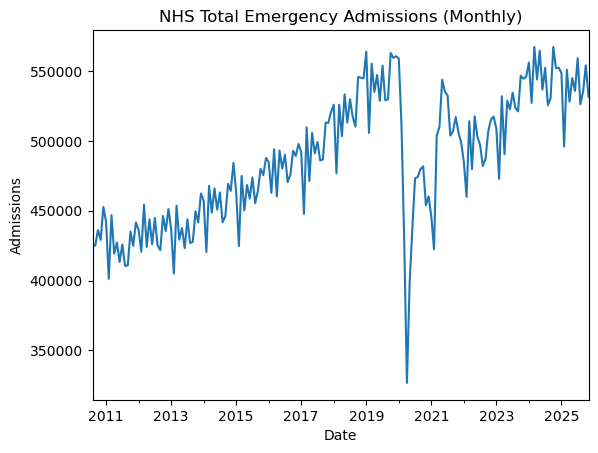

In [6]:
plt.figure()
df_ts["admissions"].plot()
plt.title("NHS Total Emergency Admissions (Monthly)")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.show()

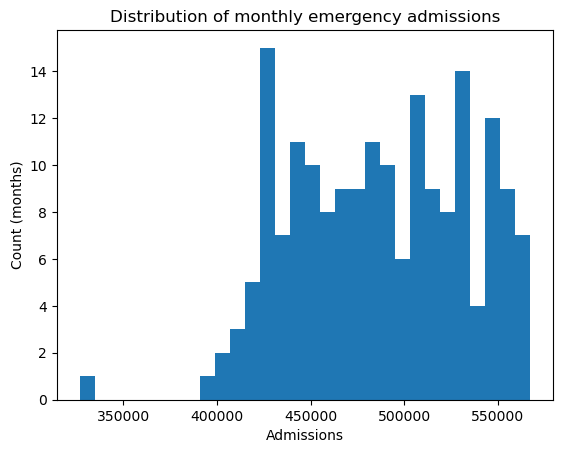

In [7]:
plt.figure()
plt.hist(df_ts["admissions"].values, bins=30)
plt.title("Distribution of monthly emergency admissions")
plt.xlabel("Admissions")
plt.ylabel("Count (months)")
plt.show()

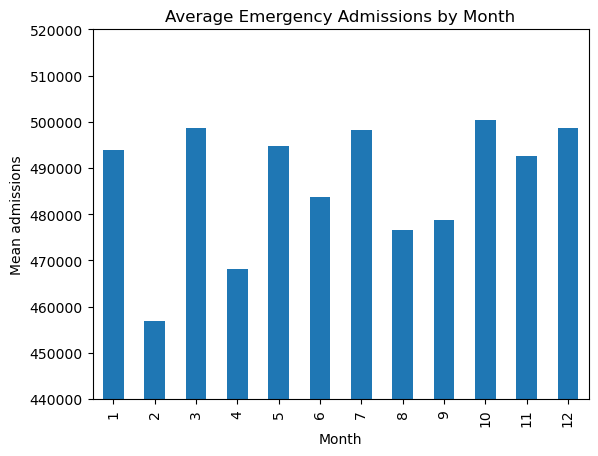

In [8]:
tmp = df_ts.copy()
tmp["month"] = tmp.index.month
month_means = tmp.groupby("month")["admissions"].mean()

plt.figure()
month_means.plot(kind="bar")
plt.title("Average Emergency Admissions by Month")
plt.xlabel("Month")
plt.ylabel("Mean admissions")

plt.ylim(440000, 520000)
plt.show()

## Train/validation split (time-based)

Because this is time series data, I avoid random splits.
I hold out the last `H` months as a validation set to simulate forecasting the future.


In [9]:
H = 6
SEASONAL_PERIOD = 12

y = df_ts["admissions"].astype(float)

train = y.iloc[:-H]
valid = y.iloc[-H:]

print("Train:", train.index.min(), "->", train.index.max(), "n=", len(train))
print("Valid:", valid.index.min(), "->", valid.index.max(), "n=", len(valid))

Train: 2010-08-01 00:00:00 -> 2025-05-01 00:00:00 n= 178
Valid: 2025-06-01 00:00:00 -> 2025-11-01 00:00:00 n= 6


## Metrics

I use:
- MAE (easy to interpret, “average error in admissions per month”)
- RMSE (penalises large errors)
- MAPE (percentage error)

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-8, np.abs(y_true)))) * 100

def evaluate(y_true, y_pred, name):
    print(name)
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", rmse(y_true, y_pred))
    print("MAPE:", mape(y_true, y_pred))
    print("-"*40)

## Baseline forecasts

Baselines are important in forecasting: advanced models should beat them.

Baselines used:
1. Naive: predict the last observed value
2. Seasonal naive: repeat the same months from last year (12-month seasonality)

In [11]:
pred_naive = np.repeat(train.iloc[-1], H)

last_year = train.iloc[-SEASONAL_PERIOD:].values
pred_snaive = np.tile(last_year, int(np.ceil(H/SEASONAL_PERIOD)))[:H]

evaluate(valid, pred_naive, "Naive baseline")
evaluate(valid, pred_snaive, "Seasonal naive baseline")

Naive baseline
MAE : 12362.333333333334
RMSE: 12851.898666474668
MAPE: 2.2928190471692944
----------------------------------------
Seasonal naive baseline
MAE : 7843.0
RMSE: 10523.49544273828
MAPE: 1.44634344971119
----------------------------------------


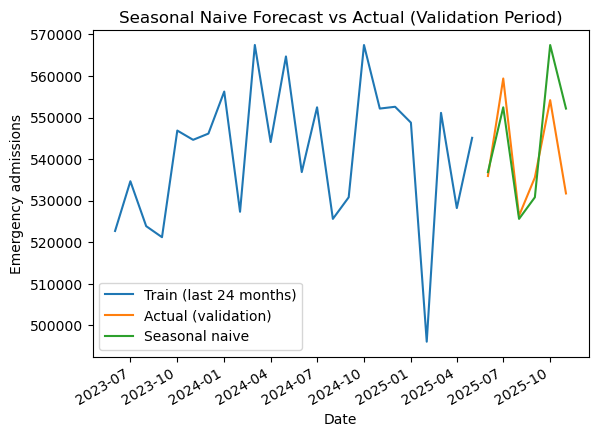

In [12]:
plt.figure()

plt.plot(train.index[-24:], train.values[-24:], label="Train (last 24 months)")
plt.plot(valid.index, valid.values, label="Actual (validation)")
plt.plot(valid.index, pred_snaive, label="Seasonal naive")

plt.title("Seasonal Naive Forecast vs Actual (Validation Period)")
plt.xlabel("Date")
plt.ylabel("Emergency admissions")
plt.legend()

plt.gcf().autofmt_xdate()  
plt.show()

## SARIMA model

SARIMA is a common statistical forecasting model that can capture:
- trends
- autocorrelation
- yearly seasonality (12 months)

I fit SARIMA on the training period and forecast the next 6 months.

In [13]:
sarima = sm.tsa.SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, SEASONAL_PERIOD),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_res = sarima.fit(disp=False)
pred_sarima = sarima_res.forecast(steps=H)

evaluate(valid, pred_sarima, "SARIMA")

SARIMA
MAE : 13063.23140911593
RMSE: 14340.115660308702
MAPE: 2.40835258352126
----------------------------------------


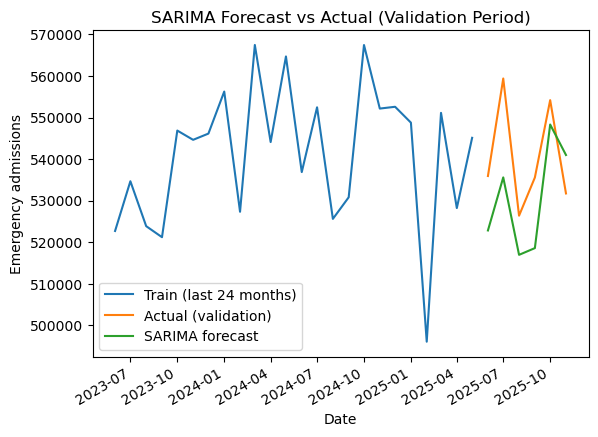

In [14]:
plt.figure()

# last 24 months of training data
plt.plot(
    train.index[-24:], 
    train.values[-24:], 
    label="Train (last 24 months)"
)

# validation period
plt.plot(valid.index, valid.values, label="Actual (validation)")
plt.plot(valid.index, pred_sarima.values, label="SARIMA forecast")

plt.title("SARIMA Forecast vs Actual (Validation Period)")
plt.xlabel("Date")
plt.ylabel("Emergency admissions")
plt.legend()

plt.gcf().autofmt_xdate()  # fix overlapping labels
plt.show()

## Machine learning approach (Random Forest with lag features)

To compare with SARIMA, I also try a machine learning approach:
- create lag features (previous months)
- add month-of-year features (sin/cos encoding)
- train a Random Forest regressor

This treats forecasting as a supervised learning problem.


In [15]:
data = df_ts.copy()

data["lag1"] = data["admissions"].shift(1)
data["lag2"] = data["admissions"].shift(2)
data["lag3"] = data["admissions"].shift(3)
data["lag6"] = data["admissions"].shift(6)
data["lag12"] = data["admissions"].shift(12)

data["month"] = data.index.month
data["month_sin"] = np.sin(2*np.pi*data["month"]/12)
data["month_cos"] = np.cos(2*np.pi*data["month"]/12)

data = data.dropna()
data.head()

,admissions,lag1,lag2,lag3,lag6,lag12,month,month_sin,month_cos
date,,,,,,,,,
2011-08-01,410554.285714,425797.857143,413320.857143,427276.571429,401206.428571,425702.000000,8,-8.660254e-01,-5.000000e-01
2011-09-01,410760.857143,410554.285714,425797.857143,413320.857143,446845.571429,424900.000000,9,-1.000000e+00,-1.836970e-16
2011-10-01,435080.142857,410760.857143,410554.285714,425797.857143,419243.285714,436215.000000,10,-8.660254e-01,5.000000e-01
2011-11-01,424887.000000,435080.142857,410760.857143,410554.285714,427276.571429,429099.000000,11,-5.000000e-01,8.660254e-01
2011-12-01,441655.285714,424887.000000,435080.142857,410760.857143,413320.857143,452728.714286,12,-2.449294e-16,1.000000e+00


In [16]:
# Slice supervised data into train/valid periods
train_ml = data.loc[train.index.min():train.index.max()].copy()
valid_ml = data.loc[valid.index.min():valid.index.max()].copy()

X_train = train_ml.drop(columns=["admissions"])
y_train_ml = train_ml["admissions"]

X_valid = valid_ml.drop(columns=["admissions"])
y_valid_ml = valid_ml["admissions"]

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train_ml)

pred_rf = rf.predict(X_valid)

evaluate(y_valid_ml, pred_rf, "Random Forest (lags)")

Random Forest (lags)
MAE : 11285.957000000015
RMSE: 12347.450616311036
MAPE: 2.096137429894335
----------------------------------------


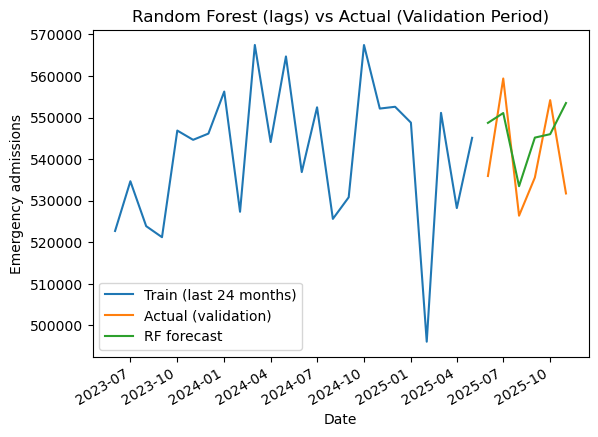

In [17]:
plt.figure()

# last 24 months of training data
plt.plot(
    train.index[-24:], 
    train.values[-24:], 
    label="Train (last 24 months)"
)

# validation period
plt.plot(valid.index, valid.values, label="Actual (validation)")
plt.plot(y_valid_ml.index, pred_rf, label="RF forecast")

plt.title("Random Forest (lags) vs Actual (Validation Period)")
plt.xlabel("Date")
plt.ylabel("Emergency admissions")
plt.legend()

plt.gcf().autofmt_xdate()
plt.show()

## Compare models

I summarise all models in a small table.
A good result is when SARIMA or the ML model improves on the seasonal naive baseline.

In [18]:
results = pd.DataFrame({
    "Model": ["Naive", "Seasonal Naive", "SARIMA", "RF (lags)"],
    "MAE": [
        mean_absolute_error(valid, pred_naive),
        mean_absolute_error(valid, pred_snaive),
        mean_absolute_error(valid, pred_sarima),
        mean_absolute_error(y_valid_ml, pred_rf),
    ],
    "RMSE": [
        rmse(valid, pred_naive),
        rmse(valid, pred_snaive),
        rmse(valid, pred_sarima),
        rmse(y_valid_ml, pred_rf),
    ],
}).sort_values("MAE")

results

,Model,MAE,RMSE
1,Seasonal Naive,7843.000000,10523.495443
3,RF (lags),11285.957000,12347.450616
0,Naive,12362.333333,12851.898666
2,SARIMA,13063.231409,14340.115660


### Model comparison

The seasonal naive baseline achieves the lowest MAE (≈7,800 admissions per month),
highlighting strong annual seasonality in NHS emergency admissions.

While both SARIMA and a lag-based Random Forest model improve on a simple naive baseline,
neither consistently outperforms the seasonal naive benchmark on the validation period.
This suggests that most of the predictive signal is driven by recurring yearly patterns.

## Final forecast (next 6 months)

Based on the validation results, the **Seasonal Naive** model performed best.
This makes sense for NHS emergency admissions because the series has strong yearly seasonality.

In this final step, I fit the Seasonal Naive approach on the full dataset and forecast the next 6 months.

In [19]:
H = 6
SEASONAL_PERIOD = 12

# Full series
y_full = df_ts["admissions"].astype(float)

# Seasonal naive forecast: repeat the last 12 months pattern
last_season = y_full.iloc[-SEASONAL_PERIOD:].values
future_values = np.tile(last_season, int(np.ceil(H / SEASONAL_PERIOD)))[:H]

# Create future index (monthly)
future_index = pd.date_range(
    start=y_full.index[-1] + pd.offsets.MonthBegin(1),
    periods=H,
    freq="MS"
)

future_forecast = pd.Series(future_values, index=future_index, name="forecast")
future_forecast

2025-12-01    552592.0
2026-01-01    548775.0
2026-02-01    496095.0
2026-03-01    551129.0
2026-04-01    528230.0
2026-05-01    545128.0
Freq: MS, Name: forecast, dtype: float64

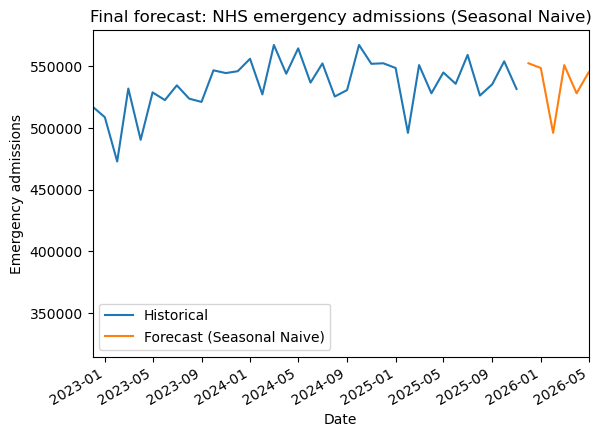

In [20]:
plt.figure()
plt.plot(y_full.index, y_full.values, label="Historical")
plt.plot(future_forecast.index, future_forecast.values, label="Forecast (Seasonal Naive)")

plt.title("Final forecast: NHS emergency admissions (Seasonal Naive)")
plt.xlabel("Date")
plt.ylabel("Emergency admissions")
plt.legend()

# keep the plot readable
plt.xlim(y_full.index[-36], future_forecast.index[-1])
plt.gcf().autofmt_xdate()

plt.show()

### Interpretation

The Seasonal Naive forecast repeats the admissions pattern observed in the same months of the previous year.
Given the strong annual seasonality in the NHS series, this provides a simple and effective short-term forecast
that can be used as an operational planning baseline.


In [21]:
compare = pd.DataFrame({
    "Last year (same months)": last_season[:H],
    "Forecast": future_forecast.values
}, index=future_forecast.index)

compare

,Last year (same months),Forecast
2025-12-01,552592.0,552592.0
2026-01-01,548775.0,548775.0
2026-02-01,496095.0,496095.0
2026-03-01,551129.0,551129.0
2026-04-01,528230.0,528230.0
2026-05-01,545128.0,545128.0


## Conclusion

This project developed an end-to-end time series forecasting pipeline to predict monthly NHS emergency
admissions using publicly available data. The analysis demonstrated that hospital admissions at national
level are highly stable and strongly seasonal, with clear winter peaks and relatively small month-to-month
variation.

Several forecasting approaches were evaluated, including naive and seasonal baselines, a SARIMA model,
and a lag-based Random Forest regression model. While both SARIMA and the machine learning approach
improved upon a simple naive forecast, the **Seasonal Naive model consistently achieved the lowest error**
on the validation period. This indicates that recurring annual patterns explain most of the variation in
emergency admissions, and that more complex models offer limited additional benefit without external
explanatory variables.

Based on these results, the Seasonal Naive approach was selected for the final forecast, providing a simple,
transparent, and robust short-term prediction for the next six months. At national scale, even small
percentage errors correspond to several thousand admissions per month, making such forecasts operationally
meaningful for capacity and staffing planning.

Future work could extend this analysis by incorporating exogenous factors such as flu incidence, weather
conditions, or public holidays, applying rolling-origin cross-validation, or modelling admissions at a
regional or hospital level where local variability may be higher.

NOTE: The dataset includes the COVID-19 period, which introduces structural changes in admissions patterns and may limit the performance of purely historical models.